In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cholesky,LinAlgError
from modified_minimize import *
torch.set_default_dtype(torch.float64)
torch.manual_seed(0)
np.random.seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEFAULT_WIDTH = 20
DEFAULT_DEPTH = 4

class PINN_U(nn.Module):
    def __init__(self, width=DEFAULT_WIDTH, depth=DEFAULT_DEPTH, parity=None):
        super(PINN_U, self).__init__()
        self.width = width
        if depth < 2:
          raise ValueError(f"depth must be at least 2, got {depth}")
        self.depth = depth
        self.act = nn.Tanh()

        # layer definitions
        self.FC_dict = nn.ModuleDict()
        self.FC_dict[f"layer 1"] = nn.Linear(1, self.width)
        for i in range(2, depth):
          self.FC_dict[f"layer {i}"] = nn.Linear(self.width, self.width)
        self.FC_dict[f"layer {depth}"] = nn.Linear(self.width, 1)

        self.parity = parity

    def forward_(self, x):
        for key, layer in self.FC_dict.items():
            x = layer(x)
            if key != f"layer {self.depth}":
                x = self.act(x)
        return x
    
    def forward(self, x1):
    
        if self.parity == 'odd':
            output = (self.forward_(x1) - self.forward_(-x1))/2
        elif self.parity == 'even':
            output = (self.forward_(x1) + self.forward_(-x1))/2   
        else:
            print('parity not recognized, should be odd or even!')
        return output

class PINN_Omega(nn.Module):
    def __init__(self, width=DEFAULT_WIDTH, depth=DEFAULT_DEPTH, parity=None):
        super(PINN_Omega, self).__init__()
        self.pinn_y1 = PINN_U(width=DEFAULT_WIDTH, depth=DEFAULT_DEPTH, parity='odd')
    
    def forward(self, x1):
        output = - x1+x1**3.5 +  self.pinn_y1(x1) * x1**4
        return output
model_U = PINN_Omega().to(device)
print(model_U)
LAMBDA_INIT = 0.4
l = torch.tensor([LAMBDA_INIT,], dtype=torch.float64, device=device, requires_grad=True)
# define an optimizer
params = list(model_U.parameters()) 


PINN_Omega(
  (pinn_y1): PINN_U(
    (act): Tanh()
    (FC_dict): ModuleDict(
      (layer 1): Linear(in_features=1, out_features=20, bias=True)
      (layer 2): Linear(in_features=20, out_features=20, bias=True)
      (layer 3): Linear(in_features=20, out_features=20, bias=True)
      (layer 4): Linear(in_features=20, out_features=1, bias=True)
    )
  )
)


In [5]:
def compute_loss(model_U,l,y1,c):
    batchsize = y1.size()[0]
    U = model_U(y1)
    Uy = grad(U.sum(), y1, create_graph=True)[0]
    #interior and smoothness losses
    Fu = -l * U + ((1+l)*torch.sinh(y1)+U)/torch.cosh(y1) * Uy
    Fu_x = grad(Fu.sum(), y1, create_graph=True)[0]
    loss_i = torch.norm(Fu)**2/batchsize
    loss_s = torch.norm(Fu_x)**2/batchsize
    # define the loss on the boundary
    z = torch.tensor([c], dtype=torch.double, device=device, requires_grad=True).reshape(1,1) # (batch, 1)
    Uf = model_U(z)
    Ufz = grad(Uf.sum(), z, create_graph=True)[0]
    loss_b =  torch.abs(Ufz/torch.cosh(z))**2
    loss =0.1*loss_i +1*loss_b +0.1*loss_s
    return [loss, loss_i, loss_b, loss_s]
def get_flat_params(model_U):
    return np.concatenate([p.detach().cpu().numpy().ravel() for p in model_U.parameters()])
def set_flat_params(model_U,flat_params):
    """Set model parameters from a flat NumPy array."""
    
    idx = 0
    for p in model_U.parameters():
        numel = p.numel()
        new_values = torch.from_numpy(flat_params[idx:idx+numel]).reshape(p.shape)
        p.data.copy_(new_values)
        idx += numel
def loss_and_grad(flat_params,model_U,l,y1,c):
    """Compute loss and gradients for BFGS."""
    set_flat_params(model_U,flat_params)  # Update model parameters
    model_U.zero_grad()
    if l.grad is not None:
        l.grad.zero_()
    [loss, loss_i, loss_b, loss_s]= compute_loss(model_U,l,y1,c)  # Compute loss
  
    # Compute gradients
    loss.backward()
    grads = np.concatenate([p.grad.detach().cpu().numpy().ravel() for p in model_U.parameters()])
   
    
    return loss.item(), grads  # SciPy requires (loss, gradients)
def lbfgsrun(model_U,l,c,batchsize,Nprint_bfgs,Nchange,Nbfgs):
    torch.manual_seed(0)
    np.random.seed(0)
    y1 = ( (c*torch.rand(batchsize, 1, device=device)))# (batch, 1) resample y
    y1.requires_grad=True
    
    # Initialize parameters
    init_params = get_flat_params(model_U)
   

    cont=0
    losses = np.zeros(Nbfgs//Nprint_bfgs+100)
    initial_scale=False
    def callback(*,intermediate_result): 
        nonlocal cont,losses
        if (cont+1)%Nprint_bfgs == 0 or cont == 0:
            loss_value = intermediate_result.fun
            losses[(cont+1)//Nprint_bfgs] = loss_value
            
    
            print(loss_value,cont+1)
        cont+=1
    H0 = torch.eye(len(init_params))
    H0 = H0.numpy()
    options={'maxiter':Nchange, 'gtol': 0, "hess_inv0":H0,
        "method_bfgs":"SSBroyden1", "initial_scale":initial_scale}
    
    while cont < Nbfgs: #Training loop
        result = minimize(loss_and_grad,init_params,args = (model_U, l,y1,c),
              method="BFGS",jac=True, options=options,
              tol=0,callback=callback) 
        init_params = result.x
    
        H0 = result.hess_inv
        H0 = (H0 + np.transpose(H0))/2
        try:
            cholesky(H0)
        except LinAlgError:
            H0 = torch.eye(len(init_params))
            H0 = H0.numpy()
    
        options={'maxiter':Nchange, 'gtol': 0, "hess_inv0":H0,
        "method_bfgs":"SSBroyden1", "initial_scale":initial_scale}
        y1 = (c*torch.rand(batchsize, 1, device=device))# (batch, 1) resample y
        y1.requires_grad=True
        #plot()
    return losses

In [6]:
losses = lbfgsrun(model_U, l,c=30,batchsize=10000,Nprint_bfgs=100,Nchange=1000,Nbfgs=20000)

54076996.36704329 1
0.1189827891832988 100
0.0017213306471733337 200
0.0013991250863274358 300
0.0009675841801619021 400
0.0007345441399035532 500
0.0005942988021914732 600
0.0005209046695546045 700
0.00045975547072402254 800
0.0003801389629605912 900
0.00029981462260488434 1000
0.0003273644125876522 1100
0.00019829771776123576 1200
0.00015956602067840236 1300
0.00012545536716356072 1400
7.771067290260457e-05 1500
1.7930873855822467e-05 1600
4.893031334211437e-06 1700
0.0022130540103124092 1800
0.00014615921427705322 1900
1.6504903933924663e-05 2000
5.741031074875365e-06 2100
3.4822034581212167e-06 2200
2.45254769949189e-06 2300
1.1794049486194058e-06 2400
7.318917668652821e-07 2500
4.829712568616805e-07 2600
3.3653168724657064e-07 2700
2.7132851780982115e-06 2800
4.6794996533998493e-07 2900
3.054370380664645e-07 3000
2.455952034667256e-07 3100
1.9757865947719195e-07 3200
1.4199293103405936e-07 3300
1.1166473150509707e-07 3400
8.442887871092291e-08 3500
6.547174802092847e-08 3600
4.870

/central/home/roywang/PINN/modified_optimize.py:1633: RuntimeWarning: invalid value encountered in sqrt
  rhokm = min(1,hk*(1-np.sqrt(np.abs(ak)/(1+ak))))
/central/home/roywang/PINN/modified_optimize.py:1635: RuntimeWarning: invalid value encountered in sqrt
  thetakp = max(1,bk*(1+np.sqrt(np.abs(ak)/(1+ak))))


7.224325544263834e-08 18300
6.2836498865946004e-09 18400
7.137922445034927e-10 18500
2.65650956652954e-10 18600
1.234644724604849e-10 18700
7.933667723586596e-11 18800
5.5639823769866194e-11 18900
6.47347627538764e-07 19000
1.794567603115334e-09 19100
2.996953828469462e-10 19200
1.0888755664390146e-10 19300
7.285680761283466e-11 19400
5.5617197714575845e-11 19500
5.0163689696553634e-11 19600
4.333449263098352e-11 19700
4.383939944106152e-09 19800
1.486203007596384e-09 19900
3.9165203193016794e-10 20000
1.29600298637346e-10 20100
7.958811447061062e-11 20200
5.6058154931690914e-11 20300
4.811434481050313e-11 20400


tensor([0.4000], device='cuda:0', requires_grad=True)


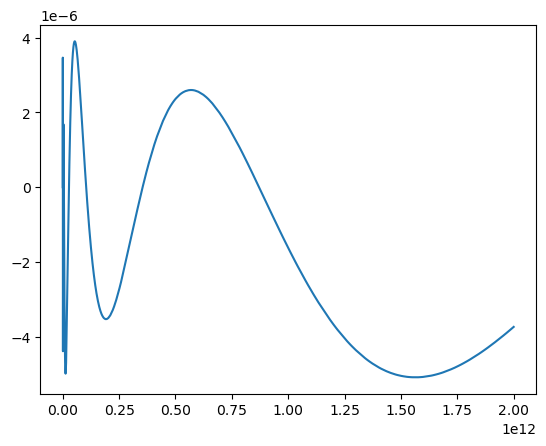

In [7]:
x = np.linspace(2000000000000,0,10001)
y = torch.tensor(np.arcsinh(x),device=device,dtype=torch.float64,requires_grad=True).reshape(10001,1)
U = model_U(y)
print(l)

Uy = grad(U.sum(), y, create_graph=True)[0]
#interior and smoothness losses
Fu = -l * U + ((1+l)*torch.sinh(y)+U)/torch.cosh(y)*Uy


fig = plt.figure()
plt.plot(x, Fu.detach().cpu().numpy())
plt.show()



In [8]:
torch.save(model_U.state_dict(), f"model_U_10000batch_20000its_weak04.pth")

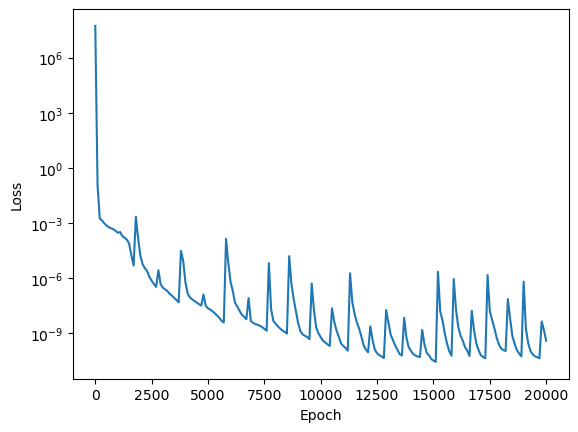

In [9]:
fig = plt.figure()
plt.xlabel('Epoch') 
plt.ylabel('Loss')
x=[i*100 for i in range(201)]
plt.semilogy(x,losses[:201])
plt.show()